In [25]:
# standard packages for data analysis and NLP

import numpy as np
import pandas as pd
from copy import deepcopy

#visualization packages
import seaborn as sns
import matplotlib.pyplot as plt

# NLP modules we will use for text normalization
import re #regex 
import nltk # the natural language toolkit
from nltk.tokenize import word_tokenize
from nltk import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk import pos_tag

# feature construction
from sklearn.feature_extraction.text import TfidfVectorizer #use this to create BoW matrix

# import pyLDAvis.sklearn # a specialized package for topic model visualization

#modeling and dimensionality reduction for visuaization
from sklearn.decomposition import NMF
from sklearn.manifold import TSNE

from langdetect import detect
import time
import pickle

# import data
and basic checks

In [26]:
df = pd.read_csv('raw_data/Steam_Game_Review_Dataset/train_gr/train.csv')
df.head()

,review_id,title,year,user_review,user_suggestion
0,1,Spooky's Jump Scare Mansion,2016.0,I'm scared and hearing creepy voices. So I'll...,1
1,2,Spooky's Jump Scare Mansion,2016.0,"Best game, more better than Sam Pepper's YouTu...",1
2,3,Spooky's Jump Scare Mansion,2016.0,"A littly iffy on the controls, but once you kn...",1
3,4,Spooky's Jump Scare Mansion,2015.0,"Great game, fun and colorful and all that.A si...",1
4,5,Spooky's Jump Scare Mansion,2015.0,Not many games have the cute tag right next to...,1


In [27]:
df.shape

(17494, 5)

In [28]:
df.year.value_counts(normalize=True)

2018.0    0.278471
2016.0    0.244052
2017.0    0.224648
2015.0    0.142065
2014.0    0.086567
2013.0    0.019635
2012.0    0.003754
2011.0    0.000809
Name: year, dtype: float64

# language detect

In [29]:
def detect_lang(t):
    try:
        lang = detect(t)
    except:
        lang = 'error'

    return lang


In [30]:
start = time.time()

df['lang'] = df['user_review'].apply(detect_lang)

end = time.time()
print(f'{end-start} seconds passed...')

78.49521040916443 seconds passed...


In [31]:
df['lang'].value_counts(normalize=True)

en       0.987710
error    0.002286
ru       0.001829
de       0.001143
vi       0.000629
es       0.000629
so       0.000572
tr       0.000514
cy       0.000457
pt       0.000457
fr       0.000343
ja       0.000343
et       0.000286
pl       0.000286
it       0.000286
ro       0.000286
th       0.000229
fi       0.000229
tl       0.000171
cs       0.000171
nl       0.000171
sv       0.000114
sk       0.000114
uk       0.000114
ko       0.000114
no       0.000114
bg       0.000057
zh-cn    0.000057
id       0.000057
hu       0.000057
el       0.000057
he       0.000057
sl       0.000057
Name: lang, dtype: float64

In [32]:
# drop all non-english
df = df[df['lang']=='en']

- length of comments

In [33]:
df['Comment_len'] = df['user_review'].map(lambda x: len(x))

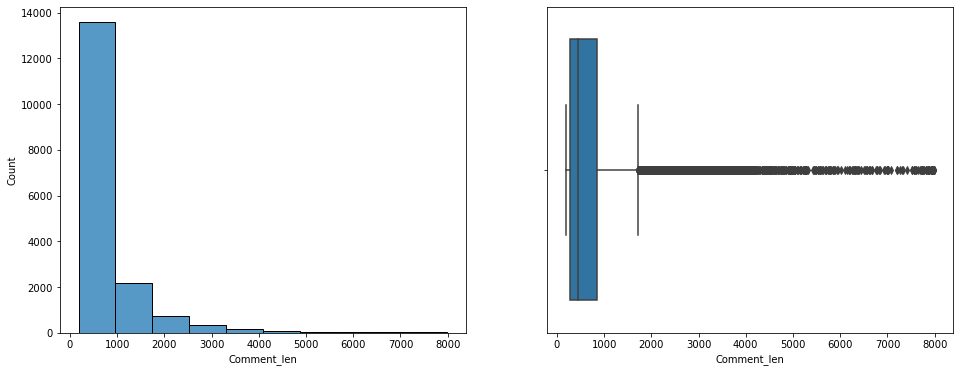

In [34]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(16,6))
sns.histplot(df['Comment_len'],bins=10, ax=ax1)
sns.boxplot(data=df, x='Comment_len', hue='year', ax=ax2);

<AxesSubplot:xlabel='year', ylabel='Comment_len'>

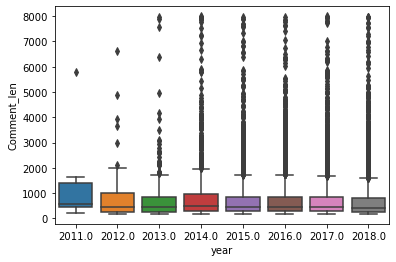

In [35]:
sns.boxplot(data=df, y='Comment_len', x='year') 

In [36]:
# year maynot make sense, it might be the year user commented

# text preprocessing

In [37]:
# additional argument sets cut off minimum length for tokenized text at which function converts to null string.
def process_text(text, min_length):
    
    # get common stop words that we'll remove during tokenization/text normalization
    stop_words = stopwords.words('english')

    #initialize lemmatizer
    wnl = WordNetLemmatizer()

    # helper function to change nltk's part of speech tagging to a wordnet format.
    def pos_tagger(nltk_tag):
        if nltk_tag.startswith('J'):
            return wordnet.ADJ
        elif nltk_tag.startswith('V'):
            return wordnet.VERB
        elif nltk_tag.startswith('N'):
            return wordnet.NOUN
        elif nltk_tag.startswith('R'):
            return wordnet.ADV
        else:         
            return None
   

    # lower case everything
    text_lower = text.lower()
    
    # remove stop words and punctuations 
    text_norm = [x for x in word_tokenize(text_lower) if ((x.isalpha()) & (x not in stop_words)) ]

    #  POS detection on the result will be important in telling Wordnet's lemmatizer how to lemmatize
    
    # creates list of tuples with tokens and POS tags in wordnet format
    wordnet_tagged = list(map(lambda x: (x[0], pos_tagger(x[1])), pos_tag(text_norm))) 

    # now we are going to have a cutoff here. any tokenized cocument with length < min length will be removed from corpus
    if len(wordnet_tagged) <= min_length:
        return ''
    else:
         # rejoins lemmatized sentence 
         text_norm = " ".join([wnl.lemmatize(x[0], x[1]) for x in wordnet_tagged if x[1] is not None])
         return text_norm

In [38]:
# subset the dataset p * origin
# then do text process
# lastly, get rid of null, na and duplicates, because of the limit of length

def subset_and_process(p, df, colname):
    
    start = time.time()

    sample_size = int(df.shape[0]*p)
    print(f'subset size: {sample_size}')
    print(f'full dataset size: {df.shape[0]}')
    print(f'{p*100}%')

    df_sub = df.sample(sample_size,random_state=2333) 
    df_sub[colname].value_counts(normalize=True)

    start = time.time()
    df_sub[colname] = df_sub[colname].apply(process_text, min_length = 10)
    end = time.time()
    print(f'{end-start} seconds slipped.')

    df_new = df_sub[df_sub[colname] != '']
    df_new.drop_duplicates(inplace=True)
    df_new.dropna(inplace=True)

    print(f'output dataset size: {df_new.shape[0]}')
    
    end = time.time()
    print(f'{end-start} secs slipped..')

    return df_new

In [39]:
preprocessed_nlp_steam_full = subset_and_process(1,df,'user_review')

subset size: 17279
full dataset size: 17279
100%
91.04864740371704 seconds slipped.
output dataset size: 17080
91.07653522491455 secs slipped..


<ipython-input-38-20de9cffe781>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new.drop_duplicates(inplace=True)
<ipython-input-38-20de9cffe781>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new.dropna(inplace=True)


In [40]:
df

,review_id,title,year,user_review,user_suggestion,lang,Comment_len
0,1,Spooky's Jump Scare Mansion,2016.0,I'm scared and hearing creepy voices. So I'll...,1,en,710
1,2,Spooky's Jump Scare Mansion,2016.0,"Best game, more better than Sam Pepper's YouTu...",1,en,335
2,3,Spooky's Jump Scare Mansion,2016.0,"A littly iffy on the controls, but once you kn...",1,en,397
3,4,Spooky's Jump Scare Mansion,2015.0,"Great game, fun and colorful and all that.A si...",1,en,280
4,5,Spooky's Jump Scare Mansion,2015.0,Not many games have the cute tag right next to...,1,en,334
...,...,...,...,...,...,...,...
17489,25535,EverQuest II,2012.0,Arguably the single greatest mmorp that exists...,1,en,984
17490,25536,EverQuest II,2017.0,"An older game, to be sure, but has its own cha...",1,en,1472
17491,25537,EverQuest II,2011.0,When I frist started playing Everquest 2 it wa...,1,en,1642
17492,25538,EverQuest II,NaN,cool game. THe only thing that REALLY PISSES M...,1,en,264


In [41]:
preprocessed_nlp_steam_full

,review_id,title,year,user_review,user_suggestion,lang,Comment_len
4278,5674,Yu-Gi-Oh! Duel Links,2018.0,worth new player take time get new card pay an...,1,en,193
15720,23155,AdventureQuest 3D,2016.0,early access reviewrereview wogloween update u...,1,en,282
13446,19390,Creativerse,2015.0,early access reviewhonestly start well tried f...,1,en,4646
7549,10559,Trove,2016.0,trion world awful really pay win go backwards ...,0,en,1181
13141,18948,Fallout Shelter,2017.0,mean fun game bore hit play fun time go repeti...,1,en,233
...,...,...,...,...,...,...,...
6582,8957,Heroes & Generals,2018.0,great game grind much start play first come wa...,0,en,283
4290,5686,Yu-Gi-Oh! Duel Links,2017.0,game bad port standpoint mean yeah grab game s...,0,en,360
8809,11819,Realm Royale,2018.0,early access reviewplayer base target really f...,1,en,903
16709,24678,Bloons TD Battles,2016.0,game honestly dumb thing steam cant sign steam...,0,en,219


In [42]:
# df.to_pickle('processed_df/preprocessed_nlp_steam_full.pkl')
preprocessed_nlp_steam_full.to_csv(r'processed_df\preprocessed_nlp_steam_full.csv', index = False)

# Topic Modeling

- 7

In [46]:
corpus = preprocessed_nlp_steam_full['user_review']
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(corpus)
X_train

<17080x38061 sparse matrix of type '<class 'numpy.float64'>'
	with 829964 stored elements in Compressed Sparse Row format>

In [47]:
topic_model = NMF(n_components = 7)
topic_model.fit(X_train)

NMF(n_components=7)

In [48]:
# to get H
H = topic_model.transform(X_train) # transform document into topic vector representation

# to get W 
W = topic_model.components_ # word component weights for each topic

print("Shape of W is " + str(W.shape))
print("Shape of H is " + str(H.shape))
print("Shape of X_train is " + str(X_train.shape))

Shape of W is (7, 38061)
Shape of H is (17080, 7)
Shape of X_train is (17080, 38061)


- W

In [51]:
for index,topic in enumerate(W):
    print(f'THE TOP 10 WORDS FOR TOPIC #{index}')
    print([vectorizer.get_feature_names()[i] for i in topic.argsort()[-25:]])
    print('\n')

THE TOP 10 WORDS FOR TOPIC #0
['think', 'look', 'graphic', 'well', 'people', 'enjoy', 'say', 'lot', 'try', 'steam', 'ever', 'hour', 'much', 'time', 'best', 'good', 'friend', 'recommend', 'love', 'really', 'free', 'great', 'fun', 'play', 'game']


THE TOP 10 WORDS FOR TOPIC #1
['duel', 'rank', 'elder', 'mode', 'gold', 'opponent', 'ai', 'reward', 'generous', 'get', 'mechanic', 'win', 'game', 'player', 'draft', 'eternal', 'play', 'mana', 'pack', 'mtg', 'draw', 'magic', 'hearthstone', 'deck', 'card']


THE TOP 10 WORDS FOR TOPIC #2
['great', 'bug', 'potential', 'make', 'bad', 'alpha', 'issue', 'graphic', 'reviewit', 'devs', 'update', 'fortnite', 'reviewthe', 'fun', 'well', 'fix', 'battle', 'royale', 'pubg', 'good', 'reviewi', 'reviewthis', 'game', 'access', 'early']


THE TOP 10 WORDS FOR TOPIC #3
['weapon', 'try', 'item', 'back', 'still', 'give', 'start', 'system', 'class', 'server', 'take', 'people', 'use', 'update', 'game', 'character', 'thing', 'level', 'go', 'even', 'time', 'make', 'n

In [52]:
%%capture topic_word_plot
def plot_top_words(W, feature_names, n_top_words, title, n_topics):
    fig, axes = plt.subplots(1, n_topics, figsize=(15, 8), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(W):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 20})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=15)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=25)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

n_top_words = 20
tfidf_feature_names = vectorizer.get_feature_names()
plot_top_words(W, tfidf_feature_names, n_top_words, "Topics in NMF model",7)

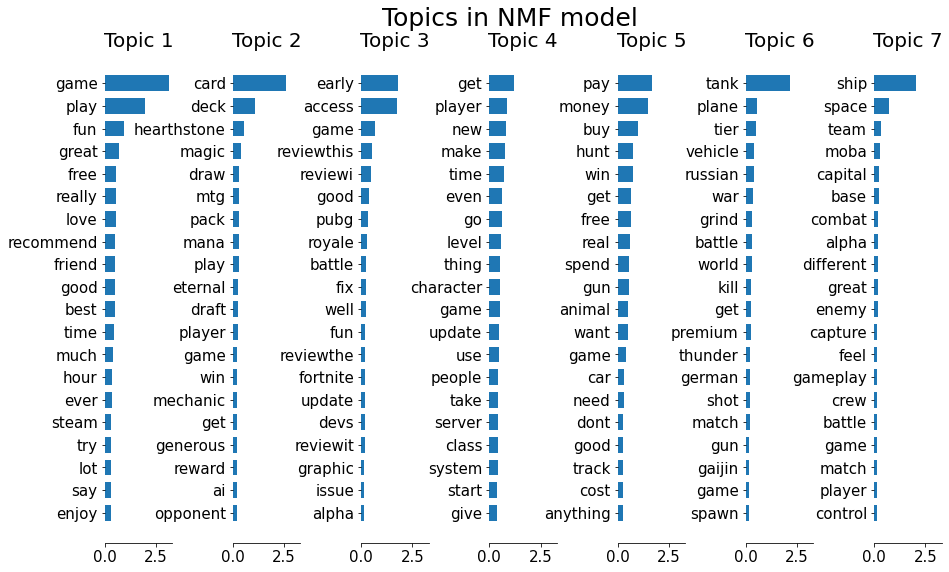

In [53]:
topic_word_plot()

In [54]:
topic_name_dict = {0: 'really fun game for friend', 1: 'magic deck card game', 2: 'PUBG Early Access',
                   3: 'fortnite type', 4: 'animal hunting', 5:'russian german war', 6:'among us'}

# TSNE

In [55]:
tsne = TSNE(random_state=42, learning_rate=100)
tsne_trans = tsne.fit_transform(H)
tsne_trans = pd.DataFrame(tsne_trans, columns = ['TSNE1', 'TSNE2'])

In [56]:
tsne_trans['class'] = np.argmax(H, axis = 1)
tsne_trans['class'] = tsne_trans['class'].replace(topic_name_dict)

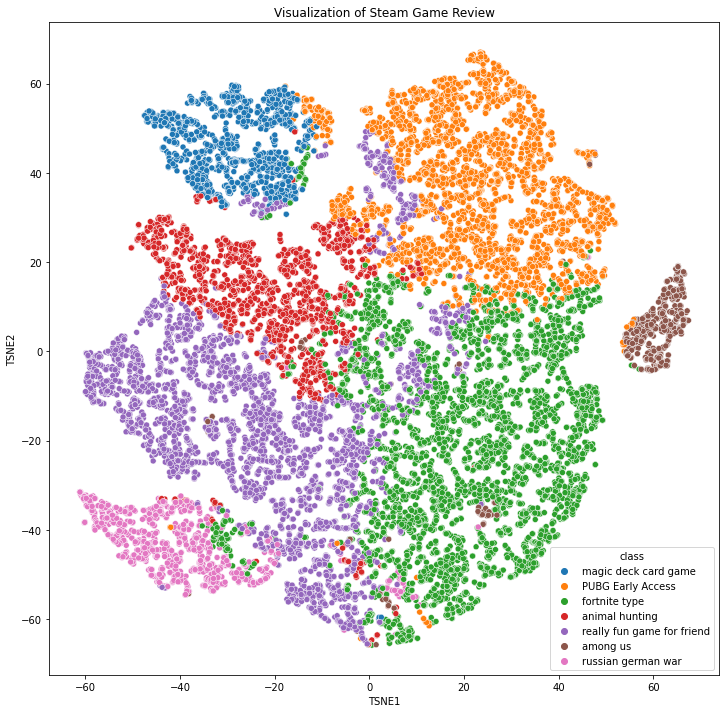

In [61]:
plt.figure(figsize=(12,12))
sns.scatterplot(x = 'TSNE1', y = 'TSNE2', hue = 'class', data = tsne_trans, palette = 'tab10')
plt.title('Visualization of Steam Game Review')
plt.show()

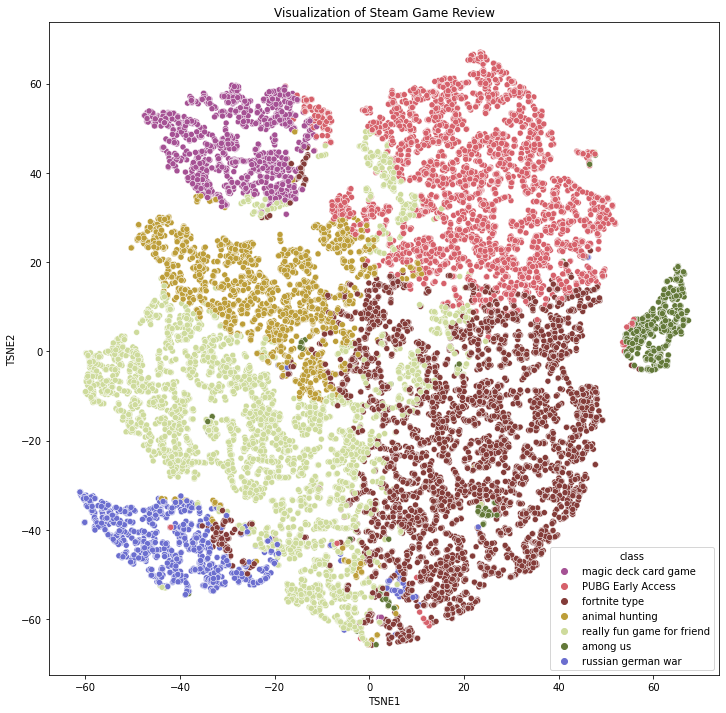

In [70]:
plt.figure(figsize=(12,12))
sns.scatterplot(x = 'TSNE1', y = 'TSNE2', hue = 'class', data = tsne_trans, palette = 'tab20b_r')
plt.title('Visualization of Steam Game Review')
plt.show()

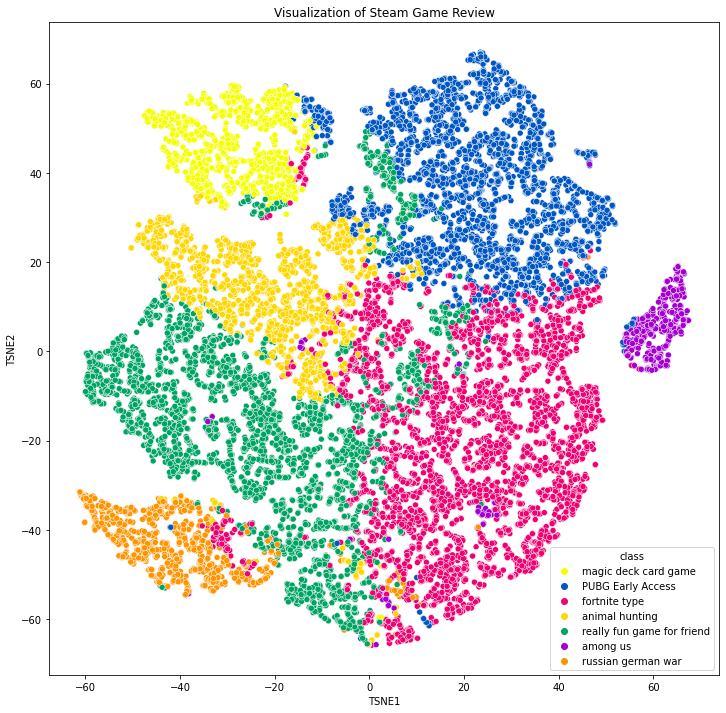

In [76]:
plt.figure(figsize=(12,12))
sns.scatterplot(x = 'TSNE1', y = 'TSNE2', hue = 'class', data = tsne_trans, palette = 'prism')
plt.title('Visualization of Steam Game Review')
plt.show()

- 12

In [77]:
topic_model_12 = NMF(n_components = 12)
topic_model_12.fit(X_train)

c:\Users\qwswe\Anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


NMF(n_components=12)

In [94]:
# to get H
H = topic_model_12.transform(X_train) # transform document into topic vector representation

# to get W 
W = topic_model_12.components_ # word component weights for each topic

print("Shape of W is " + str(W.shape))
print("Shape of H is " + str(H.shape))
print("Shape of X_train is " + str(X_train.shape))

Shape of W is (12, 38061)
Shape of H is (17080, 12)
Shape of X_train is (17080, 38061)


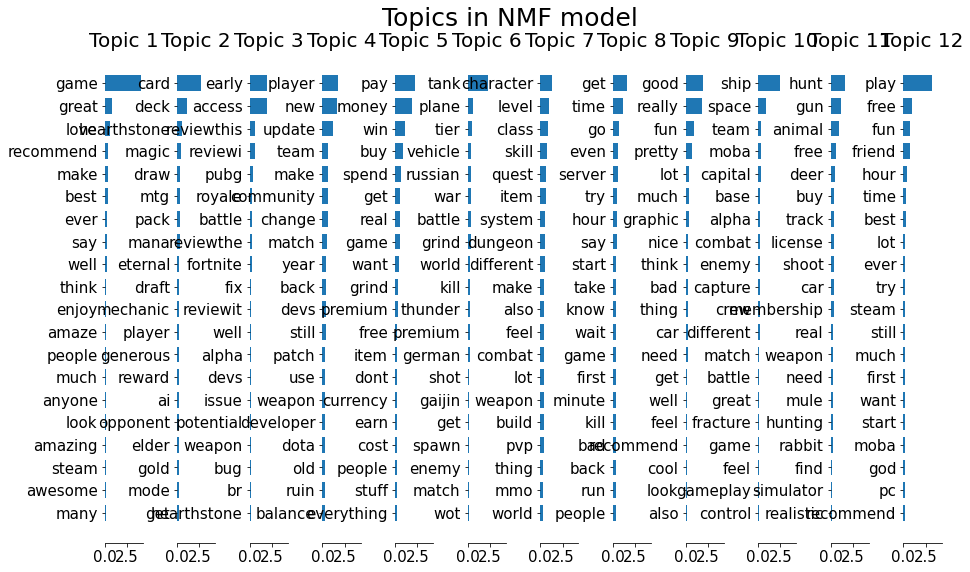

In [95]:
n_top_words = 20
tfidf_feature_names = vectorizer.get_feature_names()
plot_top_words(W, tfidf_feature_names, n_top_words, "Topics in NMF model",12)


In [96]:
topic_name_dict_12 = {0: 'game you would recommend', 1: 'magic deck card game', 2: 'Early Access battle(fortnite & PUBG)',
                   3: 'dota', 4: 'pay to win', 5:'russian german war',6:'pvp dungeon', 7:'first kill?', 8:'car', 9:'among us',
                    10:'animal hunt', 11:'general ok game'}

In [97]:
tsne = TSNE(random_state=42, learning_rate=100)
tsne_trans = tsne.fit_transform(H)
tsne_trans = pd.DataFrame(tsne_trans, columns = ['TSNE1', 'TSNE2'])

In [100]:
tsne_trans['class'] = np.argmax(H, axis = 1)
tsne_trans['class'] = tsne_trans['class'].replace(topic_name_dict_12)

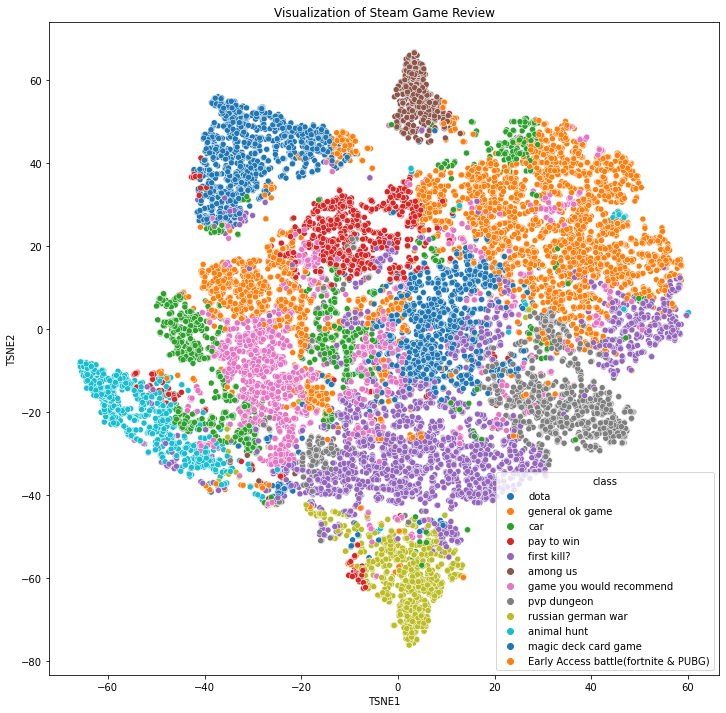

In [101]:
plt.figure(figsize=(12,12))
sns.scatterplot(x = 'TSNE1', y = 'TSNE2', hue = 'class', data = tsne_trans, palette = 'tab10')
plt.title('Visualization of Steam Game Review')
plt.show()